Install Libraries

In [ ]:
!pip install --upgrade speechbrain
!pip install mir_eval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Generate data set

In [ ]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Project/dataset_2500.zip'
with zipfile.ZipFile(zip_path, "r") as zip_ref:
  zip_ref.extractall('./dataset')

Mounted at /content/drive


Hparams yaml File


In [ ]:

!mkdir /content/dataset/metadata
!mkdir /content/dataset/metadata/test
!mkdir /content/dataset/metadata/train
!mkdir /content/dataset/metadata/validate
!mv /content/dataset/test/metadata.csv /content/dataset/metadata/test/
!mv /content/dataset/train/metadata.csv /content/dataset/metadata/train/
!mv /content/dataset/validate/metadata.csv /content/dataset/metadata/validate/
# !rm -rf './hparams'
!mkdir './hparams'
!cp '/content/drive/MyDrive/Project/sepformer.yml' './hparams/'
!cp -r '/content/drive/MyDrive/Project/pretrained_convtasnet' './'
# !cp '/content/drive/MyDrive/Project/conVasNet.yml' './hparams/'
!cp '/content/drive/MyDrive/Project/conVasNet_p.yml' './hparams/'
!cp '/content/drive/MyDrive/Project/preprocess_dynamic_mixing.py' './'
!cp '/content/drive/MyDrive/Project/dynamic_mixing.py' './'
!cp '/content/drive/MyDrive/Project/prepare_data.py' './'
# !cp -r '/content/drive/MyDrive/Project/results' './'
!cp -r '/content/drive/MyDrive/Project/results_176' './'

Prepare dataset

In [ ]:
def dataio_prep(hparams):
    """Creates data processing pipeline"""

    # 1. Define datasets
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_data"],
        replacements={"data_root": hparams["data_folder"]},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_data"],
        replacements={"data_root": hparams["data_folder"]},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_data"],
        replacements={"data_root": hparams["data_folder"]},
    )

    datasets = [train_data, valid_data, test_data]

    # 2. Provide audio pipelines

    @sb.utils.data_pipeline.takes("mix_wav")
    @sb.utils.data_pipeline.provides("mix_sig")
    def audio_pipeline_mix(mix_wav):
        mix_sig = sb.dataio.dataio.read_audio(mix_wav)
        return mix_sig

    @sb.utils.data_pipeline.takes("s1_wav")
    @sb.utils.data_pipeline.provides("s1_sig")
    def audio_pipeline_s1(s1_wav):
        s1_sig = sb.dataio.dataio.read_audio(s1_wav)
        return s1_sig

    @sb.utils.data_pipeline.takes("s2_wav")
    @sb.utils.data_pipeline.provides("s2_sig")
    def audio_pipeline_s2(s2_wav):
        s2_sig = sb.dataio.dataio.read_audio(s2_wav)
        return s2_sig

    @sb.utils.data_pipeline.takes("languages")
    @sb.utils.data_pipeline.provides("lang_id")
    def lang_id_pipeline(lang_str):
      lang_id = lang_str.split(',')
      yield encode_languages(lang_id)

    @sb.utils.data_pipeline.takes("length")
    @sb.utils.data_pipeline.provides("lens")
    def length_pipeline(length):
      return length

    if hparams["num_spks"] == 3:

        @sb.utils.data_pipeline.takes("s3_wav")
        @sb.utils.data_pipeline.provides("s3_sig")
        def audio_pipeline_s3(s3_wav):
            s3_sig = sb.dataio.dataio.read_audio(s3_wav)
            return s3_sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_mix)
    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_s1)
    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_s2)
    sb.dataio.dataset.add_dynamic_item(datasets, lang_id_pipeline)
    sb.dataio.dataset.add_dynamic_item(datasets, length_pipeline)
    if hparams["num_spks"] == 3:
      sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_s3)
      sb.dataio.dataset.set_output_keys(datasets, ["id", "mix_sig", "s1_sig", "s2_sig", "s3_sig", "lang_id", "lens"])
    else:
      sb.dataio.dataset.set_output_keys(datasets, ["id", "mix_sig", "s1_sig", "s2_sig", "lang_id", "lens"])

    return train_data, valid_data, test_data

def encode_languages(language_list):
  label = []
  for lang in language_list:
    vec = torch.zeros(16)
    label_encoder = hparams["label_encoder"]
    label_encoder.expect_len(16) #new Line Added
    label_encoder.update_from_iterable(hparams["all_langs"])
    idx = label_encoder.encode_label(lang)
    vec[idx] = 1.0
    label.append(vec)
  label = torch.stack(label)
  # print(f"Label = {label}")
  return label

Model

In [ ]:
import csv
import os
import sys
import io

import numpy as np
import torch
from  speechbrain.nnet.losses import PitWrapper
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm

import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger
from speechbrain.utils.train_logger import FileTrainLogger
from speechbrain.nnet.losses import bce_loss, PitWrapper
from speechbrain.utils.metric_stats import ClassificationStats





class MultiTask(sb.Brain):
  def on_stage_start(self, stage, epoch):
    # if stage != sb.Stage.TRAIN:
      # self.error_metrics = self.hparams.error_stats()
    self.train_epoch_acc = 0
    self.test_epoch_acc_p = 0
    self.test_epoch_acc = 0
    self.val_epoc_acc_s = 0
    self.val_epoc_acc_p = 0
    self.all_embeddings = []
    self.all_labels = []
    self.print_num =0;
    if stage == sb.Stage.TRAIN:
      if epoch < 40:
        self.hparams.delta_lang_loss = 1.0
        self.hparams.delta_separate_loss = 0.0
        for name in ['encoder', 'masknet', 'decoder']:
            for param in getattr(self.modules, name).parameters():
                param.requires_grad = False
      elif epoch == 40:
        self.hparams.delta_lang_loss = 0.95
        self.hparams.delta_separate_loss = 0.05
        logger.info("Unfreezing Convtasnet")
        for name in ['encoder', 'masknet', 'decoder']:
            for param in getattr(self.modules, name).parameters():
                param.requires_grad = True
        unfrozen_params = filter(lambda p: p.requires_grad, self.modules.parameters())
        self.optimizer = torch.optim.Adam(unfrozen_params, lr=self.hparams.lr, weight_decay=0)

    self.uttid = [0]
    if stage in [sb.Stage.VALID, sb.Stage.TEST]:
      self.stats = ClassificationStats()
    self.file_logger = FileTrainLogger("/content/results/print_statements")
    self.pit_bce = PitWrapper(nn.BCEWithLogitsLoss(reduction='none'))


  def compute_forward(self, mix, targets, lang_id,  stage):
    mix, mix_lens = mix
    mix, mix_lens = mix.to(self.device), mix_lens.to(self.device)
    targets = torch.stack([t.data for t in targets], dim=-1).to(self.device)
    if stage == sb.Stage.TRAIN:
      with torch.no_grad():
        if self.hparams.use_speedperturb:
            mix, targets = self.add_speed_perturb(targets, mix_lens)

            mix = targets.sum(-1)

        if self.hparams.use_wavedrop:
            mix = self.hparams.drop_chunk(mix, mix_lens)
            mix = self.hparams.drop_freq(mix)

        if self.hparams.limit_training_signal_len:
            mix, targets = self.cut_signals(mix, targets)

    #ConvTasNet
    with torch.amp.autocast(device_type='cuda', enabled=False):
      mixe = self.hparams.Encoder(mix)
      est_mask = self.hparams.MaskNet(mixe)
    mixe = torch.stack([mixe] * self.hparams.num_spks)
    sep_h = mixe * est_mask
    est_source = torch.cat([self.hparams.Decoder(sep_h[i]).unsqueeze(-1) for i in range(self.hparams.num_spks)], dim=-1)
    T_origin = mix.size(1)
    T_est = est_source.size(1)
    if T_origin > T_est:
        est_source = F.pad(est_source, (0, 0, 0, T_origin - T_est))
    else:
        est_source = est_source[:, :T_origin, :]

    #ECAPA-TDNN
    batch_size, seq_len, num_spks = est_source.shape
    est_source_combined = est_source.view(batch_size * num_spks, seq_len)
    feats = self.modules.compute_features(est_source_combined)
    mix_len_combined = mix_lens.repeat(num_spks)
    feats = self.modules.mean_var_norm(feats, mix_len_combined)
    embeddings = self.modules.embedding_model(feats, mix_len_combined)
    outputs = self.modules.classifier(embeddings)
    pred_lang_id = outputs.view(batch_size, num_spks, -1)
    return est_source, targets, lang_id, mix_lens, pred_lang_id, embeddings

  def lang_accuracy(self, lang_id, probs):
    # print(f"lang_id_size = {lang_id.shape}, probs = {probs.shape}")
    lang_id = lang_id.squeeze(0)
    probs = probs.squeeze(0)
    # print(f"lang_id_size = {lang_id.shape}, probs = {probs.shape}")
    acc1_s = (torch.sum(probs[0,0] * lang_id[0]) + torch.sum(probs[0,1] * lang_id[1])) /2
    acc2_s = (torch.sum(probs[0,0] * lang_id[1]) + torch.sum(probs[0,1] * lang_id[0])) /2

    preds = torch.argmax(probs.unsqueeze(0), dim=-1)     # shape: [1, 2]
    targets = torch.argmax(lang_id, dim=-1)

    acc1_p = int(preds[0,0] == targets[0]) + int(preds[0,1] == targets[1])
    acc2_p = int(preds[0,0] == targets[1]) + int(preds[0,1] == targets[0])
    return max(acc1_s, acc2_s).item(), max(acc1_p, acc2_p)/2

  def compute_objectives(self, predictions, targets, lang_id, lens, pred_lang_id,stage, uttid):
    # print("predictions:",predictions, "targets = ", targets)

    separate_loss = self.hparams.loss(targets, predictions)
    lang_id = lang_id.data.float().to(pred_lang_id.device)
    predictions = pred_lang_id.transpose(1,2)
    targets = lang_id.transpose(1,2)
    lang_loss, perms = self.pit_bce(predictions,targets)
    separate_loss = separate_loss.mean()
    lang_loss = lang_loss.mean()

    loss = self.hparams.delta_lang_loss * lang_loss + self.hparams.delta_separate_loss*separate_loss
    self.file_logger.log_stats(stats_meta = {"Target size = ":targets.size(), "Predictions size =": predictions.size(), "lang_id = ": lang_id, "pred_lang_id = ": pred_lang_id, "stage =":stage, "Separate loss =": separate_loss, "lang_loss = ":lang_loss,"Loss =":loss, "Perms =": perms}, verbose=False)
    if stage == sb.Stage.VALID or stage == sb.Stage.TEST:
      probs = torch.sigmoid(pred_lang_id)
      preds = torch.argmax(probs, dim=-1)       # Shape: [1, 2]
      target_language = torch.argmax(lang_id, dim=-1)
      for b in range(preds.shape[0]):
          for spk in range(preds.shape[1]):
              self.stats.append(
                  ids=[f"utt{b}_spk{spk}"],
                  predictions=[self.hparams.all_langs[preds[b, spk].item()]],
                  targets=[self.hparams.all_langs[target_language[b, spk].item()]],
                  categories=self.hparams.all_langs
              )
    if stage == sb.Stage.TEST:
      probs = torch.sigmoid(pred_lang_id)
      lang_acc_s,lang_acc_p = self.lang_accuracy(lang_id,probs)
      self.test_epoch_acc = (self.test_epoch_acc*(self.uttid[0]-1) + lang_acc_s)*(1/self.uttid[0])
      self.test_epoch_acc_p = (self.test_epoch_acc_p*(self.uttid[0]-1) + lang_acc_p)*(1/self.uttid[0])

    return loss,lang_loss,separate_loss

  def fit_batch(self,batch):
    mixture = batch.mix_sig
    targets = [batch.s1_sig, batch.s2_sig]
    lang_id = batch.lang_id
    self.uttid[0] = self.uttid[0] + 1
    with torch.amp.autocast(device_type='cuda'):
      est_source, targets, lang_id, lens, pred_lang_id,embeddings = self.compute_forward(
        mixture, targets, lang_id, sb.Stage.TRAIN
      )
      loss,lang_loss,separate_loss = self.compute_objectives(
        est_source, targets, lang_id, lens, pred_lang_id,sb.Stage.TRAIN, self.uttid
      )
      # self.lang_loss_epoch = lang_loss.mean()
      # self.sep_loss_epoch = separate_loss.mean()
      if self.hparams.threshold_byloss:
        th = self.hparams.threshold
        loss = loss[loss > th]
        if loss.nelement() > 0:
            loss = loss.mean()
      else:
        loss = loss.mean()

    if loss.nelement() > 0 and loss < self.hparams.loss_upper_lim:
      self.scaler.scale(loss).backward()
      if self.hparams.clip_grad_norm >= 0:
        self.scaler.unscale_(self.optimizer)
        torch.nn.utils.clip_grad_norm_(
          self.modules.parameters(),
          self.hparams.clip_grad_norm,
        )
      self.scaler.step(self.optimizer)
      self.scaler.update()
    else:
      self.nonfinite_count += 1
      logger.info(
        "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
          self.nonfinite_count
        )
      )
      loss.data = torch.tensor(0.0).to(self.device)
    self.optimizer.zero_grad()

    return loss.detach().cpu()


  def evaluate_batch(self, batch, stage):

    """Computations needed for validation/test batches"""
    snt_id = batch.id
    mixture = batch.mix_sig
    targets = [batch.s1_sig, batch.s2_sig]
    lang_id = batch.lang_id
    self.uttid[0] = self.uttid[0] + 1
    if self.hparams.num_spks == 3:
      targets.append(batch.s3_sig)

    with torch.no_grad():
      # compute_forward returns multiple values for multi-task
      est_source, targets, lang_id, lens, pred_lang_id, embeddings = self.compute_forward(
        mixture, targets, lang_id,  stage
      )
      # compute_objectives combines both tasks into a single loss
      loss,lang_loss,separate_loss = self.compute_objectives(
        est_source, targets, lang_id, lens, pred_lang_id, stage, self.uttid
      )
    if stage == sb.Stage.TEST and self.hparams.save_audio:

      if hasattr(self.hparams, "n_audio_to_save"):
        if self.hparams.n_audio_to_save > 0:
          self.save_audio(snt_id[0], mixture, targets, est_source)
          self.hparams.n_audio_to_save += -1
      else:
        self.save_audio(snt_id[0], mixture, targets, est_source)


    return loss.mean().detach()

  def on_stage_end(self, stage, stage_loss, epoch):
    stage_stats = {"final_loss": stage_loss}
    log_buffer = io.StringIO()
    if stage == sb.Stage.TRAIN:
      self.train_stats = stage_stats
      # train_loss.append(self.train_stats["final_loss"])
      file_loc = f"/content/results_{epoch}"
      if(epoch%2 ==0):
        os.rename(r"/content/results", file_loc)
        !cp -r $file_loc '/content/drive/MyDrive/Project'
        if(epoch > 2):
          prev_file_loc = f"/content/drive/MyDrive/Project/results_{epoch-2}"
          !rm -rf $prev_file_loc
          logger.info(f"Removed file {prev_file_loc}")
        os.rename(file_loc,r"/content/results")
        logger.info("Saved file succesfully")
    if stage == sb.Stage.TEST or stage == sb.Stage.VALID:
      summary = self.stats.summarize()
      self.stats.write_stats(log_buffer)  # Write stats into buffer instead of stdout
      log_text = log_buffer.getvalue()
    if stage == sb.Stage.VALID:
      # Learning rate annealing
      # epoch_list.append(epoch)
      if isinstance(self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau):
        current_lr, next_lr = self.hparams.lr_scheduler(
            [self.optimizer], epoch, stage_loss
        )
        schedulers.update_learning_rate(self.optimizer, next_lr)
      else:
        # if we do not use the reducelronplateau, we do not change the lr
        current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

      self.hparams.train_logger.log_stats(
          stats_meta={"epoch": epoch, "lr": current_lr, "Stats":log_text},
          train_stats=self.train_stats,
          valid_stats={"final_loss": stage_loss, "Overall Accuracy:" : summary["accuracy"], "Classwise Accuracy: ":summary["classwise_accuracy"]},
          verbose = False
      )
      print(f"Epoch : {epoch}, Current_lr: {current_lr}, Train Loss: {self.train_stats['final_loss']}, Validation Loss: {stage_loss}, Validation Accuracy: {summary['accuracy']}")
      # val_accuracy_s.append(self.val_epoc_acc_s)
      # val_accuracy_p.append(self.val_epoc_acc_p)

      # valid_loss.append(stage_stats["final_loss"])

      self.checkpointer.save_and_keep_only(
          meta={"final_loss": stage_stats["final_loss"]}, min_keys=["final_loss"]
      )
    elif stage == sb.Stage.TEST:
      self.hparams.train_logger.log_stats(

        stats_meta={"Epoch loaded": self.hparams.epoch_counter.current, "Accuracy soft": self.test_epoch_acc, "Accuracy Partial" : self.test_epoch_acc_p},
        test_stats=stage_stats,
      )
    log_buffer.close()

  def add_speed_perturb(self, targets, targ_lens):
    """Adds speed perturbation and random_shift to the input signals"""

    min_len = -1
    recombine = False

    if self.hparams.use_speedperturb or self.hparams.use_rand_shift:
      # Performing speed change (independently on each source)
      new_targets = []
      recombine = True

      for i in range(targets.shape[-1]):
        new_target = self.hparams.speed_perturb(targets[:, :, i])
        new_targets.append(new_target)
        if i == 0:
          min_len = new_target.shape[-1]
        else:
          if new_target.shape[-1] < min_len:
            min_len = new_target.shape[-1]

      if self.hparams.use_rand_shift:
        # Performing random_shift (independently on each source)
        recombine = True
        for i in range(targets.shape[-1]):
            rand_shift = torch.randint(
                self.hparams.min_shift, self.hparams.max_shift, (1,)
            )
            new_targets[i] = new_targets[i].to(self.device)
            new_targets[i] = torch.roll(
                new_targets[i], shifts=(rand_shift[0],), dims=1
            )

        # Re-combination
        if recombine:
            if self.hparams.use_speedperturb:
                targets = torch.zeros(
                    targets.shape[0],
                    min_len,
                    targets.shape[-1],
                    device=targets.device,
                    dtype=torch.float,
                )
            for i, new_target in enumerate(new_targets):
                targets[:, :, i] = new_targets[i][:, 0:min_len]

    mix = targets.sum(-1)
    return mix, targets

  def cut_signals(self, mixture, targets):
      """This function selects a random segment of a given length within the mixture.
      The corresponding targets are selected accordingly"""
      randstart = torch.randint(
          0,
          1 + max(0, mixture.shape[1] - self.hparams.training_signal_len),
          (1,),
      ).item()
      targets = targets[
          :, randstart : randstart + self.hparams.training_signal_len, :
      ]
      mixture = mixture[
          :, randstart : randstart + self.hparams.training_signal_len
      ]
      return mixture, targets


  def reset_layer_recursively(self, layer):
      """Reinitializes the parameters of the neural networks"""
      if hasattr(layer, "reset_parameters"):
          layer.reset_parameters()
      for child_layer in layer.modules():
          if layer != child_layer:
              self.reset_layer_recursively(child_layer)

  def save_results(self, test_data):

    """This script computes the SDR and SI-SNR metrics and saves
    them into a csv file"""

    # This package is required for SDR computation
    from mir_eval.separation import bss_eval_sources

    # Create folders where to store audio
    save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

    # Variable init
    all_sdrs = []
    all_sdrs_i = []
    all_sisnrs = []
    all_sisnrs_i = []
    csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]

    test_loader = sb.dataio.dataloader.make_dataloader(
      test_data, **self.hparams.dataloader_opts
    )

    with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
      writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
      writer.writeheader()

      # Loop over all test sentence
      with tqdm(test_loader, dynamic_ncols=True) as t:
          for i, batch in enumerate(t):
            # Apply Separation
            mixture, mix_len = batch.mix_sig
            snt_id = batch.id
            targets = [batch.s1_sig, batch.s2_sig]
            lang_id = batch.lang_id
            # lens = batch.lens
            self.uttid[0] = self.uttid[0] + 1
            if self.hparams.num_spks == 3:
              targets.append(batch.s3_sig)

            with torch.no_grad():
              predictions, targets, lang_id, lens, pred_lang_id, embeddings = self.compute_forward(
                  batch.mix_sig, targets, lang_id,  sb.Stage.TEST
              )

            # Compute SI-SNR
            total_loss,lang_loss,sisnr = self.compute_objectives(predictions, targets,lang_id,lens,pred_lang_id, sb.Stage.TEST, self.uttid)

            # Compute SI-SNR improvement
            mixture_signal = torch.stack(
              [mixture] * self.hparams.num_spks, dim=-1
            )
            mixture_signal = mixture_signal.to(targets.device)
            total_loss,lang_loss,sisnr_baseline = self.compute_objectives(
              mixture_signal, targets, lang_id, lens, pred_lang_id, sb.Stage.TEST, self.uttid
            )
            sisnr_i = sisnr - sisnr_baseline

            # Compute SDR
            ref = targets[0].t().cpu().numpy()
            est = predictions[0].t().detach().cpu().numpy()
            if np.any(np.all(ref == 0, axis=1)):
              print(f"Skipping uttid: {self.uttid[0]} as all the targets are zero")
              continue
            sdr, _, _, _ = bss_eval_sources(ref,est)

            sdr_baseline, _, _, _ = bss_eval_sources(ref,est)


            sdr_i = sdr.mean() - sdr_baseline.mean()

            # Saving on a csv file
            row = {
              "snt_id": snt_id[0],
              "sdr": sdr.mean(),
              "sdr_i": sdr_i,
              "si-snr": -sisnr.item(),
              "si-snr_i": -sisnr_i.item(),
            }
            writer.writerow(row)

            # Metric Accumulation
            all_sdrs.append(sdr.mean())
            all_sdrs_i.append(sdr_i.mean())
            all_sisnrs.append(-sisnr.item())
            all_sisnrs_i.append(-sisnr_i.item())

          row = {
            "snt_id": "avg",
            "sdr": np.array(all_sdrs).mean(),
            "sdr_i": np.array(all_sdrs_i).mean(),
            "si-snr": np.array(all_sisnrs).mean(),
            "si-snr_i": np.array(all_sisnrs_i).mean(),
          }
          writer.writerow(row)

    logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
    logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
    logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
    logger.info("Mean SDRi is {}".format(np.array(all_sisnrs_i).mean()))

  def save_audio(self, snt_id, mixture, targets, predictions):
    "saves the test audio (mixture, targets, and estimated sources) on disk"

    # Create output folder
    save_path = os.path.join(self.hparams.save_folder, "audio_results")
    if not os.path.exists(save_path):
      os.mkdir(save_path)

    for ns in range(self.hparams.num_spks):
      # Estimated source
      signal = predictions[0, :, ns]
      signal = signal / signal.abs().max()
      save_file = os.path.join(
        save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
      )
      torchaudio.save(
        save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
      )

      # Original source
      signal = targets[0, :, ns]
      signal = signal / signal.abs().max()
      save_file = os.path.join(
        save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
      )
      torchaudio.save(
        save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
      )

    # Mixture
    signal = mixture[0][0, :]
    signal = signal / signal.abs().max()
    save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
    torchaudio.save(
      save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
    )
  # def get_language(path):
  #   mixture = sb.dataio.dataio.read_audio(torchaudio.load())


Main

In [ ]:
# Load hyperparameters file with command-line overrides
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.empty_cache()
args = ["/content/hparams/conVasNet_p.yml"]
hparams_file, run_opts, overrides = sb.parse_arguments(args)


epochs = 200
with open(hparams_file, encoding="utf-8") as fin:
  hparams = load_hyperpyyaml(fin, overrides)

# Initialize ddp (useful only for multi-GPU DDP training)
sb.utils.distributed.ddp_init_group(run_opts)

# Logger info
logger = get_logger(__name__)

# Create experiment directory
sb.create_experiment_directory(
  experiment_directory=hparams["output_folder"],
  hyperparams_to_save=hparams_file,
  overrides=overrides,
)

# Update precision to bf16 if the device is CPU and precision is fp16
if run_opts.get("device") == "cpu" and hparams.get("precision") == "fp16":
  hparams["precision"] = "bf16"

# Check if wsj0_tr is set with dynamic mixing
if hparams["dynamic_mixing"] and not os.path.exists(hparams["base_folder_dm"]):
  raise ValueError("Please, specify a valid base_folder_dm folder when using dynamic mixing")

import sys
sys.path.append('/content/')

# Data preparation
from prepare_data import prepare_wsjmix  # noqa

run_on_main(
    prepare_wsjmix,
    kwargs={
        "datapath": hparams["data_folder"],
        "savepath": hparams["save_folder"],
        "n_spks": hparams["num_spks"],
        "skip_prep": hparams["skip_prep"],
        "fs": hparams["sample_rate"],
    },
)

# Create dataset objects
if hparams["dynamic_mixing"]:
    from dynamic_mixing import dynamic_mix_data_prep

    # if the base_folder for dm is not processed, preprocess them
    if "processed" not in hparams["base_folder_dm"]:
        # if the processed folder already exists we just use it otherwise we do the preprocessing
        if not os.path.exists(
            os.path.normpath(hparams["base_folder_dm"]) + "_processed"
        ):
            from preprocess_dynamic_mixing import resample_folder

            print("Resampling the base folder")
            run_on_main(
                resample_folder,
                kwargs={
                    "input_folder": hparams["base_folder_dm"],
                    "output_folder": os.path.normpath(
                        hparams["base_folder_dm"]
                    )
                    + "_processed",
                    "fs": hparams["sample_rate"],
                    "regex": "**/*.wav",
                },
            )
            # adjust the base_folder_dm path
            hparams["base_folder_dm"] = (
                os.path.normpath(hparams["base_folder_dm"]) + "_processed"
            )
        else:
            print(
                "Using the existing processed folder on the same directory as base_folder_dm"
            )
            hparams["base_folder_dm"] = (
                os.path.normpath(hparams["base_folder_dm"]) + "_processed"
            )

    # Collecting the hparams for dynamic batching
    dm_hparams = {
        "train_data": hparams["train_data"],
        "data_folder": hparams["data_folder"],
        "base_folder_dm": hparams["base_folder_dm"],
        "sample_rate": hparams["sample_rate"],
        "num_spks": hparams["num_spks"],
        "training_signal_len": hparams["training_signal_len"],
        "dataloader_opts": hparams["dataloader_opts"],
    }
    train_data = dynamic_mix_data_prep(dm_hparams)
    _, valid_data, test_data = dataio_prep(hparams)
else:
    train_data, valid_data, test_data = dataio_prep(hparams)

trainfile_test,sr = torchaudio.load("/content/dataset/train/mix/Indian_eng_as_9000.wav")

logger.info(f"Train sampling rate:{sr}")

# Load pretrained model if pretrained_separator is present in the yaml
# if "pretrained_separator" in hparams:
#     run_on_main(hparams["pretrained_separator"].collect_files, kwargs={"default_source": "speechbrain/sepformer-wsj02mix"})
#     hparams["pretrained_separator"].load_collected()

# Brain class initialization
separator = MultiTask(
    modules=hparams["modules"],
    opt_class=hparams["optimizer"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)




# # re-initialize the parameters if we don't use a pretrained model
# if "pretrained_separator" not in hparams:
#   for module in separator.modules.values():
#       separator.reset_layer_recursively(module)
# else:
#   logger.info(f"Loading pretrained weights:{separator}")
#   pretrain = hparams["pretrained_separator"]
#   pretrain.collect_files()
#   pretrain.load_collected()


separator.fit(
    separator.hparams.epoch_counter,
    train_data,
    valid_data,
    train_loader_kwargs=hparams["dataloader_opts"],
    valid_loader_kwargs=hparams["dataloader_opts"],
)

speechbrain.utils.seed - Setting seed to 1234
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/convtasnet/1234
Creating a csv file for a custom dataset
__main__ - Train sampling rate:16000
speechbrain.core - Info: precision arg from hparam file is used
speechbrain.core - Info: noprogressbar arg from hparam file is used
speechbrain.core - Gradscaler enabled: `False`
speechbrain.core - Using training precision: `--precision=fp32`
speechbrain.core - Using evaluation precision: `--eval_precision=fp32`
speechbrain.core - MultiTask Model Statistics:
* Total Number of Trainable Parameters: 27.8M
* Total Number of Parameters: 27.8M
* Trainable Parameters represent 100.0000% of the total size.
speechbrain.utils.checkpoints - Loadi

  1%|          | 14/1250 [00:03<04:54,  4.20it/s, train_loss=-8.37]


KeyboardInterrupt: 

Graph loss and accuracy

[0.222, 0.222, 0.222, 0.222, 0.223, 0.222, 0.222, 0.222, 0.221, 0.222, 0.223, 0.222, 0.222, 0.223, 0.221, 0.222, 0.222, 0.222, 0.223, 0.222, 0.222, 0.222, 0.222, 0.222, 0.222, 0.222, 0.222, 0.222, 0.223, 0.222, 0.221, 0.222, 0.221, 0.222, 0.221, 0.221, 0.222, 0.142, 0.0355, -0.0373, -0.0883, -0.143, -0.183, -0.214, -0.242, -0.269, -0.292, -0.307, -0.328, -0.349, -0.36, -0.373, -0.389, -0.403, -0.411, -0.42, -0.429, -0.443, -0.451, -0.457, -0.474, -0.479, -0.487, -0.494, -0.504, -0.499, -0.51, -0.521, -0.526, -0.535, -0.537, -0.539, -0.55, -0.55, -0.565, -0.567, -0.571, -0.571, -0.572, -0.584, -0.581, -0.59, -0.595, -0.594, -0.599, -0.612, -0.624, -0.644, -0.648, -0.65, -0.654, -0.658, -0.661, -0.664, -0.661, -0.674, -0.68, -0.672, -0.677, -0.683, -0.674, -0.677, -0.681, -0.684, -0.687, -0.679, -0.68, -0.682, -0.684, -0.678, -0.679, -0.681, -0.678, -0.679, -0.68, -0.679, -0.68, -0.68, -0.68, -0.68, -0.681, -0.681, -0.681, -0.681, -0.681, -0.681, -0.681, -0.681, -0.681, -0.681, -0.681, -

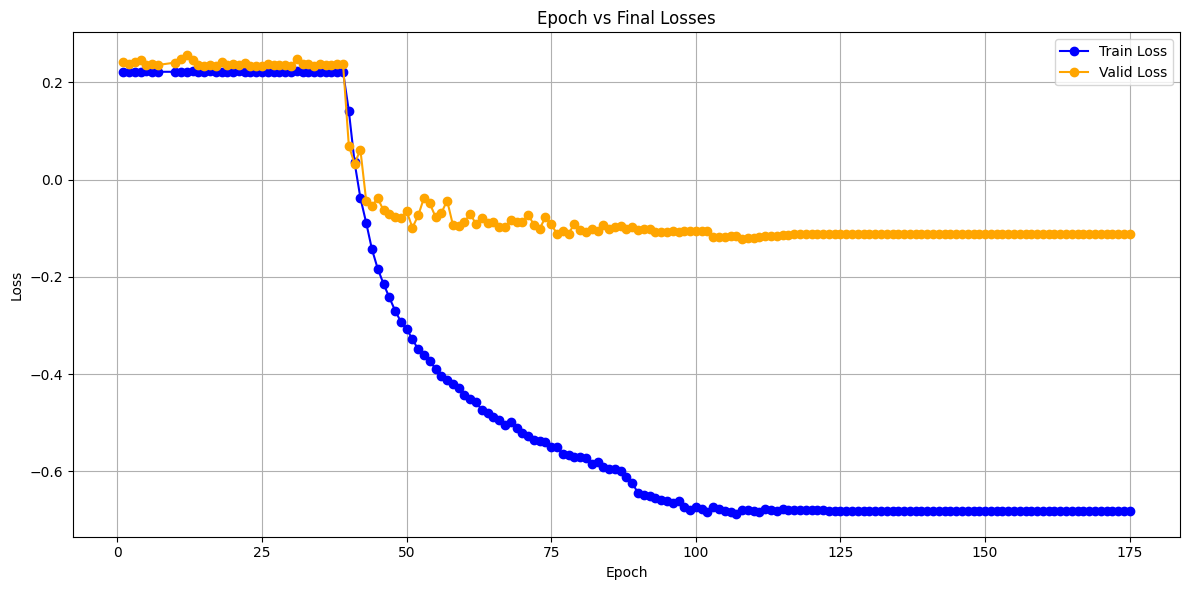

In [ ]:
from logging import NullHandler
import re
import matplotlib.pyplot as plt

# Initialize empty lists
epochs = []
valid_accuracies = []
train_losses = []
valid_losses = []
separate_loss = []
lang_loss = []

# Read and parse the log file
with open('/content/results/convtasnet/1234/train_log.txt', 'r') as file:
  epoch_match = None
  train_loss_match = None
  valid_loss_match = None
  for line in file:
      # Use regular expressions to extract values
      if(epoch_match == None):
        epoch_match = re.search(r'epoch: (\d+)', line)
      # acc_match = re.search(r'Valid Accuracy: ([\deE\+\-\.]+)', line)
      if(train_loss_match == None):
        train_loss_match = re.search(r'train final_loss: ([\deE\+\-\.]+)', line)
      if(valid_loss_match == None):
        valid_loss_match = re.search(r'valid final_loss: ([\deE\+\-\.]+)', line)
      # print(valid_loss_match)
      # separate_loss_match = re.search(r'valid separate_loss: ([\deE\+\-\.]+)', line)
      # lang_loss_match = re.search(r'valid lang_loss: ([\deE\+\-\.]+)', line)

      if epoch_match and train_loss_match and valid_loss_match :
          epochs.append(int(epoch_match.group(1)))
          # valid_accuracies.append(float(acc_match.group(1)))
          train_losses.append(float(train_loss_match.group(1)))
          valid_losses.append(float(valid_loss_match.group(1)))
          epoch_match = None
          train_loss_match = None
          valid_loss_match = None

print(train_losses)
print(valid_losses)
# Plotting
plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, valid_accuracies, marker='o', label='Valid Accuracy', color='green')
# plt.title("Epoch vs Valid Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.legend()

# plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, marker='o', label='Train Loss', color='blue')
plt.plot(epochs, valid_losses, marker='o', label='Valid Loss', color='orange')
# plt.plot(epochs, separate_loss, marker='o', label='Separate Loss', color='red')
# plt.plot(epochs, lang_loss, marker='o', label='Lang Loss', color='purple')
plt.title("Epoch vs Final Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Evaluate

In [ ]:
# Eval
separator.evaluate( test_data, min_key="si-snr")

speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.


100%|██████████| 750/750 [01:07<00:00, 11.13it/s]

speechbrain.utils.train_logger - Epoch loaded: 176, Accuracy soft: 4.36e-02, Accuracy Partial: 1.14e-01 - test final_loss: -3.25e+00


-3.2517144298047014

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
separator.save_results(test_data)

End Run

In [ ]:
!rm -rf /content/results
# !cp -r /content/results /content/drive/MyDrive/Project/
# !cp -r /content/hparams/conVasNet.yml /content/drive/MyDrive/Project/results/

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
# import torch
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.manifold import TSNE

# all_embeddings = []
# all_labels = []
# all_epochs = []

# # Folder where your .pt files are stored
# embedding_dir = "/content/"  # Change to your path

# # Load all epoch files
# for epoch in range(1, 12):
#     file_path = os.path.join(embedding_dir, f"embeddings_epoch{epoch}.pt")

#     emb = torch.load(file_path)
#     embeddings = emb["embeddings"].squeeze(1)  # from [N, 1, D] → [N, D]
#     labels = emb["labels"]  # assumes each file has (embeddings, lang_id)

#     all_embeddings.append(embeddings)
#     all_labels.append(labels)
#     all_epochs.append(torch.full((embeddings.size(0),), epoch))

# # Concatenate everything
# all_embeddings = torch.cat(all_embeddings, dim=0)
# all_labels = torch.cat(all_labels, dim=0)
# all_epochs = torch.cat(all_epochs, dim=0)

# # Run t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# reduced_emb = tsne.fit_transform(all_embeddings.numpy())

# # Plot
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x=reduced_emb[:, 0], y=reduced_emb[:, 1], hue=all_epochs.numpy(), palette="viridis", s=10)
# plt.title("t-SNE of Embeddings Over Epochs")
# plt.xlabel("TSNE-1")
# plt.ylabel("TSNE-2")
# plt.legend(title="Epoch", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.grid(True)
# plt.show()


In [ ]:
!cp /content/hparams/conVasNet_p.yml /content/drive/MyDrive/Project